# Netflix Movies & TV Shows Analysis

This notebook loads, cleans, analyzes, and visualizes the Netflix titles dataset. Steps:

1. Load dataset
2. Clean data (remove nulls, duplicates)
3. Analyze (genre distribution, Movies vs TV Shows)
4. Visualize with matplotlib/seaborn
5. Present results (graphs + summary)

Dataset path: `netflix_titles.csv/netflix_titles.csv`


In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Plot style
sns.set(style="whitegrid", context="talk")

# Ensure figures directory exists
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)


In [2]:
# Load dataset
DATA_PATH = os.path.join("netflix_titles.csv", "netflix_titles.csv")

df = pd.read_csv(DATA_PATH)
print("Rows:", len(df))
print("Columns:", len(df.columns))
df.head(3)


Rows: 8807
Columns: 12


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


In [3]:
# Clean data: strip whitespace, handle nulls, drop duplicates, parse dates

df = df.copy()

# Standardize column names
df.columns = [c.strip() for c in df.columns]

# Strip whitespace from string columns
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str).str.strip().replace({"nan": np.nan})

# Parse dates
if "date_added" in df.columns:
    df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")

# Convert release_year to Int64 (nullable)
if "release_year" in df.columns:
    df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce").astype("Int64")

# Critical fields: keep rows with non-null type and title
critical_cols = [c for c in ["type", "title"] if c in df.columns]
df = df.dropna(subset=critical_cols)

# Fill less critical text fields
for col in ["director", "cast", "country", "rating"]:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

# Handle listed_in (genres)
if "listed_in" in df.columns:
    df["listed_in"] = df["listed_in"].fillna("Unknown")

# Drop duplicate show_id or full-row duplicates
if "show_id" in df.columns:
    before = len(df)
    df = df.sort_values(by=["show_id"]).drop_duplicates(subset=["show_id"], keep="first")
    print(f"Dropped {before - len(df)} duplicate show_id rows")
else:
    before = len(df)
    df = df.drop_duplicates()
    print(f"Dropped {before - len(df)} duplicate full rows")

print("Remaining rows:", len(df))
df.sample(3, random_state=42)


Dropped 0 duplicate show_id rows
Remaining rows: 8807


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5471,s5472,Movie,Joshua: Teenager vs. Superpower,Joe Piscatella,Unknown,United States,2017-05-26,2017,TV-14,79 min,Documentaries,"Mobilized by teenage activist Joshua Wong, you..."
4023,s4024,TV Show,The Land of Hypocrisy,Unknown,"Mohamed Henedy, Dalal Abdel Aziz, Hana Shiha, ...",Egypt,2019-03-13,2018,TV-14,1 Season,"International TV Shows, TV Comedies, TV Sci-Fi...",A hardworking man in a thankless job meets a m...
5943,s5944,Movie,Adam: His Song Continues,Robert Markowitz,"Daniel J. Travanti, JoBeth Williams, Richard M...",United States,2011-10-01,1986,TV-MA,96 min,Dramas,"After their child was abducted and murdered, J..."


C:\Users\kaush\AppData\Local\Temp\ipykernel_20816\312393354.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=type_counts.index, y=type_counts.values, palette="pastel")


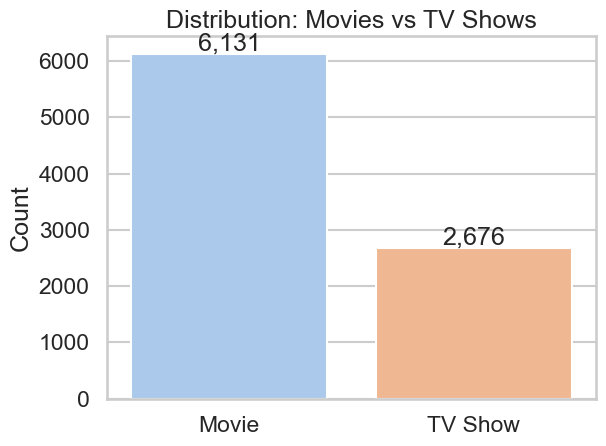

In [4]:
# Movies vs TV Shows distribution

if "type" in df.columns:
    type_counts = df["type"].value_counts().sort_index()
    ax = sns.barplot(x=type_counts.index, y=type_counts.values, palette="pastel")
    ax.set_title("Distribution: Movies vs TV Shows")
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    for i, v in enumerate(type_counts.values):
        ax.text(i, v + max(type_counts.values)*0.01, f"{int(v):,}", ha="center")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "fig_movies_vs_tv.png"), dpi=150)
    plt.show()
else:
    print("Column 'type' not found")


C:\Users\kaush\AppData\Local\Temp\ipykernel_20816\4242273827.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_genres.values, y=top_genres.index, palette="mako")


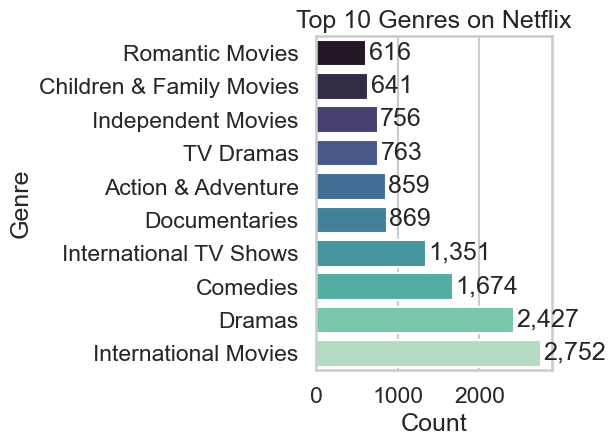

In [5]:
# Genre distribution (Top 10)

if "listed_in" in df.columns:
    genres = (
        df["listed_in"]
        .str.split(",")
        .explode()
        .str.strip()
        .replace({"": np.nan})
        .dropna()
    )
    genre_counts = genres.value_counts()
    top_n = 10
    top_genres = genre_counts.head(top_n)[::-1]  # reverse for horizontal bar

    ax = sns.barplot(x=top_genres.values, y=top_genres.index, palette="mako")
    ax.set_title(f"Top {top_n} Genres on Netflix")
    ax.set_xlabel("Count")
    ax.set_ylabel("Genre")
    for i, v in enumerate(top_genres.values):
        ax.text(v + max(top_genres.values)*0.01, i, f"{int(v):,}", va="center")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "fig_top_genres.png"), dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("Column 'listed_in' not found")


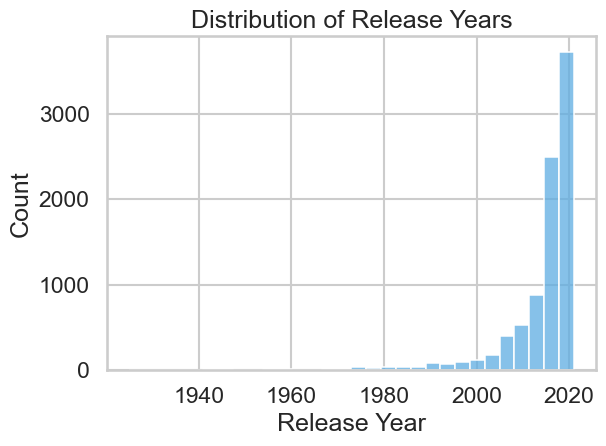

In [6]:
# Release year distribution (optional)

if "release_year" in df.columns:
    ax = sns.histplot(df["release_year"].dropna().astype(int), bins=30, kde=False, color="#5DADE2")
    ax.set_title("Distribution of Release Years")
    ax.set_xlabel("Release Year")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "fig_release_years.png"), dpi=150)
    plt.show()
else:
    print("Column 'release_year' not found")


In [7]:
# Summary metrics
summary = {}

summary["total_titles"] = int(len(df))
summary["num_movies"] = int((df["type"] == "Movie").sum()) if "type" in df.columns else None
summary["num_tv_shows"] = int((df["type"] == "TV Show").sum()) if "type" in df.columns else None

if "listed_in" in df.columns:
    top_genre = (
        df["listed_in"].str.split(",").explode().str.strip().value_counts().idxmax()
        if df["listed_in"].notna().any() else None
    )
    summary["top_genre"] = top_genre

if "release_year" in df.columns and df["release_year"].notna().any():
    summary["median_release_year"] = int(df["release_year"].median())

summary


{'total_titles': 8807,
 'num_movies': 6131,
 'num_tv_shows': 2676,
 'top_genre': 'International Movies',
 'median_release_year': 2017}

## Results Summary

- **Total titles analyzed**: see `summary["total_titles"]`
- **Movies vs TV Shows**: see counts above and saved figure `figures/fig_movies_vs_tv.png`.
- **Top genres**: see bar chart `figures/fig_top_genres.png`.
- **Release year distribution**: see `figures/fig_release_years.png`.

You can refine by region, rating, or time trends if needed.
